# Whole session raster

It crates a visualization in which the spikes rasters from all units in a recording are shown across the entire session. 
In addition to the spike rasters, it shows a couple basic kinematics metrics like speed and arena location.


In [34]:
# imports
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from scipy.signal import medfilt

import matplotlib.patheffects as path_effects
from matplotlib.artist import Artist
from myterial import amber_darker, green_dark, grey_darker, blue_darker

sys.path.append("./")
sys.path.append(r"C:\Users\Federico\Documents\GitHub\pysical_locomotion")

from data.dbase.db_tables import Probe, Unit, Session, ValidatedSession, Recording, Tracking
from data.data_utils import convolve_with_gaussian
from myterial import amber_darker, green_dark, grey_darker, blue_darker

save_folder = Path(r"D:\Dropbox (UCL)\Rotation_vte\Locomotion\analysis\ephys")

# print all available recordings
print(*zip(*Recording().fetch("name", "recording_probe_configuration")), sep="\n")




def outline(artist: Artist, lw: float = 1, color: str = "white"):
    artist.set_path_effects(
        [path_effects.withStroke(linewidth=lw, foreground=color,)]
    )

('FC_210715_AAA1110750_r5_hairpin', 'longcolumn')
('FC_210716_AAA1110750_r6_hairpin', 'longcolumn')
('FC_210720_AAA1110750_hairpin', 'longcolumn')
('FC_210721_AAA1110750_hairpin', 'longcolumn')
('FC_210722_AAA1110750_hairpin', 'longcolumn')
('FC_211022_BAA110516_hairpin', 'longcolumn')
('FC_211027_BAA110516_hairpin', 'longcolumn')
('FC_211214_BAA110517_hairpin', 'b0')
('FC_220114_BAA110517_hairpin', 'b0')
('FC_220117_BAA110517_hairpin', 'b0')
('FC_220119_BAA110517_hairpin', 'b0')
('FC_220120_BAA110517_hairpin', 'b0')
('FC_210917_BAA1110279_hairpin', 'b0')
('FC_210820_BAA1110281_hairpin', 'longcolumn')
('FC_210829_BAA1110281_hairpin', 'longcolumn')
('FC_210830_BAA1110281_hairpin', 'longcolumn')
('FC_210831_BAA1110281_hairpin', 'longcolumn')
('FC_210901_BAA1110281_hairpin', 'longcolumn')
('FC_210906_BAA1110281_hairpin', 'b0')
('FC_210917_BAA1110281_hairpin', 'b0')


choose a recording and load the data

In [35]:
REC = "FC_210831_BAA1110281_hairpin"

metadata = pd.DataFrame(
    (Recording & f'name="{REC}"').fetch()
)

tracking = Tracking.get_session_tracking(REC)
print(tracking)

units = pd.DataFrame(Unit * Unit.Spikes * Probe.RecordingSite & f'name="{REC}"')
units = units.sort_values("brain_region", inplace=False).reset_index()


mouse_id                                                   BAA1110281
name                                     FC_210831_BAA1110281_hairpin
bpname                                                           body
orientation         [263.2221909712088, 248.0719881966579, 274.476...
angular_velocity    [15793.331458272529, -909.0121664730524, 1584....
speed               [16.258761509027146, 15.194170474778758, 24.01...
acceleration        [16.258761509027146, -1.0645910342483873, 8.82...
theta               [184.76008693132673, 185.31553221100674, 187.9...
thetadot            [11085.605215879603, 33.32671678080058, 159.15...
thetadotdot         [11085.605215879603, -11052.278499098802, 125....
x                   [25.49565450371506, 25.735919879747886, 25.972...
y                   [57.10009239474049, 57.010520421705436, 57.102...
bp_speed            [16.258761509027146, 15.194170474778758, 24.01...
moving              [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...
walking             

## make plot

C:\ProgramData\Miniconda3\envs\dev\lib\site-packages\ipykernel_launcher.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator


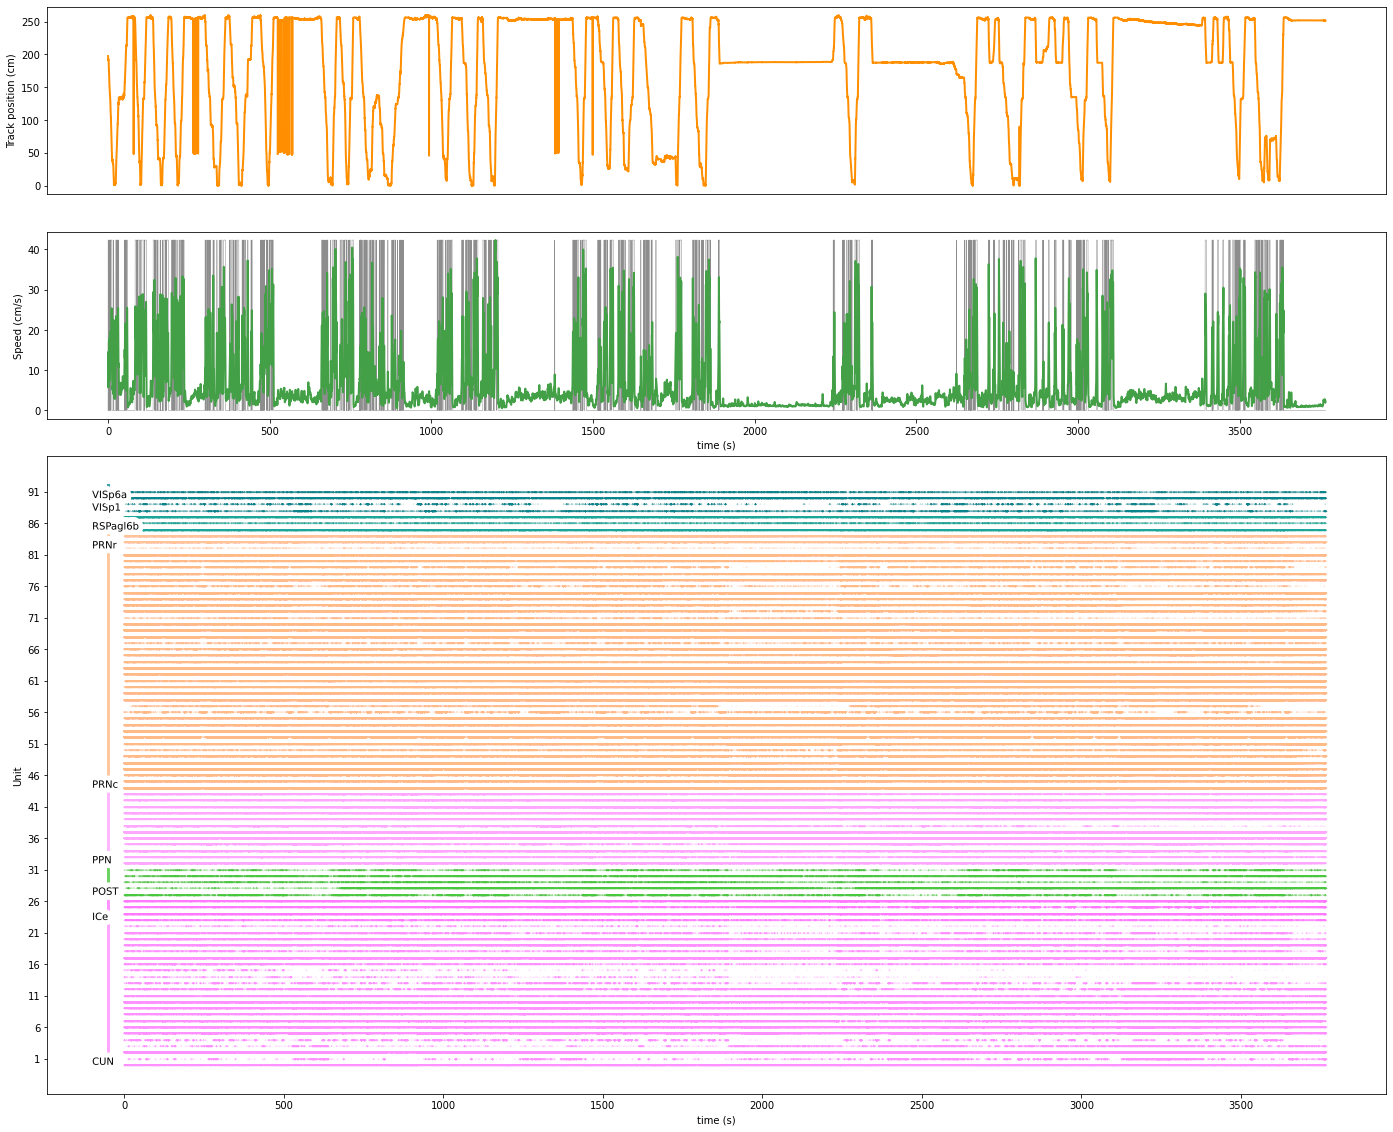

In [37]:
fig = plt.figure(figsize=(24, 20))

axes = fig.subplot_mosaic(
"""
    AAAAA
    BBBBB
    DDDDD
    DDDDD
    DDDDD
"""
)

tracking_time = np.arange(0,len(tracking.x+1)) / 60


# plot kinematics
axes["A"].plot(tracking_time, tracking.global_coord * 260, lw=2, color=amber_darker)
axes["A"].set(ylabel="Track position (cm)", xticks=[])

speed = convolve_with_gaussian(tracking.speed, 180)
_ =axes["B"].plot(tracking_time, medfilt(tracking.walking * np.max(speed), 31), lw=.5, alpha=.6, color=grey_darker)
_ =axes["B"].plot(tracking_time, speed, lw=2, color=green_dark)
_ =axes["B"].set(ylabel="Speed (cm/s)", xlabel="time (s)")


# plot spikes raster
nunits = len(units)
h = 1/nunits
# axes["D"].vlines(tracking_time[tracking.walking == 1], ymin=0, ymax=1, zorder=-1, color=grey_darker, lw=.5, alpha=.1)


regions = [ ]
last_added = 0
last_added_color = "black"
for (i, unit) in units.iterrows():
    spikes = unit.spikes_ms / 1000
    y = np.zeros_like(spikes) + (i * h)
    axes["D"].scatter(spikes, y, s=1, color=unit.color, alpha=0.1, marker=7)

    # add region as text
    if unit.brain_region not in regions:
        axes["D"].plot([-50, -50], [last_added, i * h], lw=3, color=last_added_color, alpha=0.8)
        last_added = i * h
        last_added_color = unit.color

        txt = axes["D"].text(-100, (i * h) , unit.brain_region, color="black", fontsize=10)
        outline(txt, lw=10, color="white")
        regions.append(unit.brain_region)
axes["D"].plot([-50, -50], [last_added, 1], lw=3, color=last_added_color, alpha=0.8)

_ = axes["D"].set(ylabel="Unit", xlabel="time (s)", yticklabels=np.arange(1, nunits + 1, step=5), yticks=np.arange(1, nunits + 1, step=5)/nunits)



# save figure as svg
fig.savefig(save_folder / f"{REC}_raster.png", dpi=100, bbox_inches="tight")